This script requires all prediction result csvs for the corresponding target.
They are generated using the `predict_cognition.submit` script.

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import font_manager
import os
import numpy as np

In [30]:
# Set global variables
RESULT_ROOT = "/Users/amelie/Datasets/clinical_dmri_benchmark/prediction_results/remove_confounds_features"
TBV_AS_CONFOUND = False
TARGET = "cpxresAZv2"
SAVE_ROOT = "../../figures/prediction"
os.makedirs(SAVE_ROOT, exist_ok=True)
# accuracy score can be test_neg_mean_squared_error or test_r_corr
ACCURACY_SCORE = "test_r_corr"

if TBV_AS_CONFOUND == True:
    RESULT_ROOT = RESULT_ROOT + "/include_TBV"
    SAVE_NAME = f"prediction_results_{TARGET}_includeTBV.svg"
else:
    SAVE_NAME = f"prediction_results_{TARGET}.svg"

if ACCURACY_SCORE == "test_r_corr":
    y_label = "test r"
elif ACCURACY_SCORE == "test_neg_mean_squared_error":
    y_label = "test negative MSE"
    SAVE_NAME = SAVE_NAME[:-4] + "_MSE.svg"
else:
    raise ValueError(f"Unsupported ACCURACY_SCORE: {ACCURACY_SCORE}")

In [31]:
# Define function to load separate prediction result csvs and add column for run + feature group
def load_result_csv(path_to_csv: str, run: str, target: str, reconstruction: str, features: str = None):
    df = pd.read_csv(path_to_csv)
    df["reconstruction"] = reconstruction
    df["run"] = run.replace("-", "").replace("0", "")
    df["target"] = target[:-4]
    df["target_run"] = df["target"] + "_" + df["run"]
    if features != None:
        df["features"] = features
        df["run_features"] = df["run"] + "_" + df["features"]
    else:
        df["model"] = df["target"] + "_" + \
            df["run"] + "_" + df["reconstruction"]
    return df

In [32]:
# Read all prediction csvs and combine them to one large dataframe
dfs = []
for i, run in enumerate(["run-01", "run-02"]):
    for j, reconstruction in enumerate(["GQI", "CSD", "SS3T"]):
        for k, features in enumerate(["md-fa-volume", "total_volume", "dti_fa", "md"]):
            csv_path = f"{RESULT_ROOT}/{features}/{reconstruction}_{run}_{TARGET}.csv"
            if i+j+k == 0:
                result_df = load_result_csv(
                    csv_path, run, TARGET, reconstruction, features)
                dfs.append(result_df)
            else:
                df = load_result_csv(csv_path, run, TARGET,
                                     reconstruction, features)
                dfs.append(df)
                result_df = pd.concat([result_df, df], ignore_index=True)

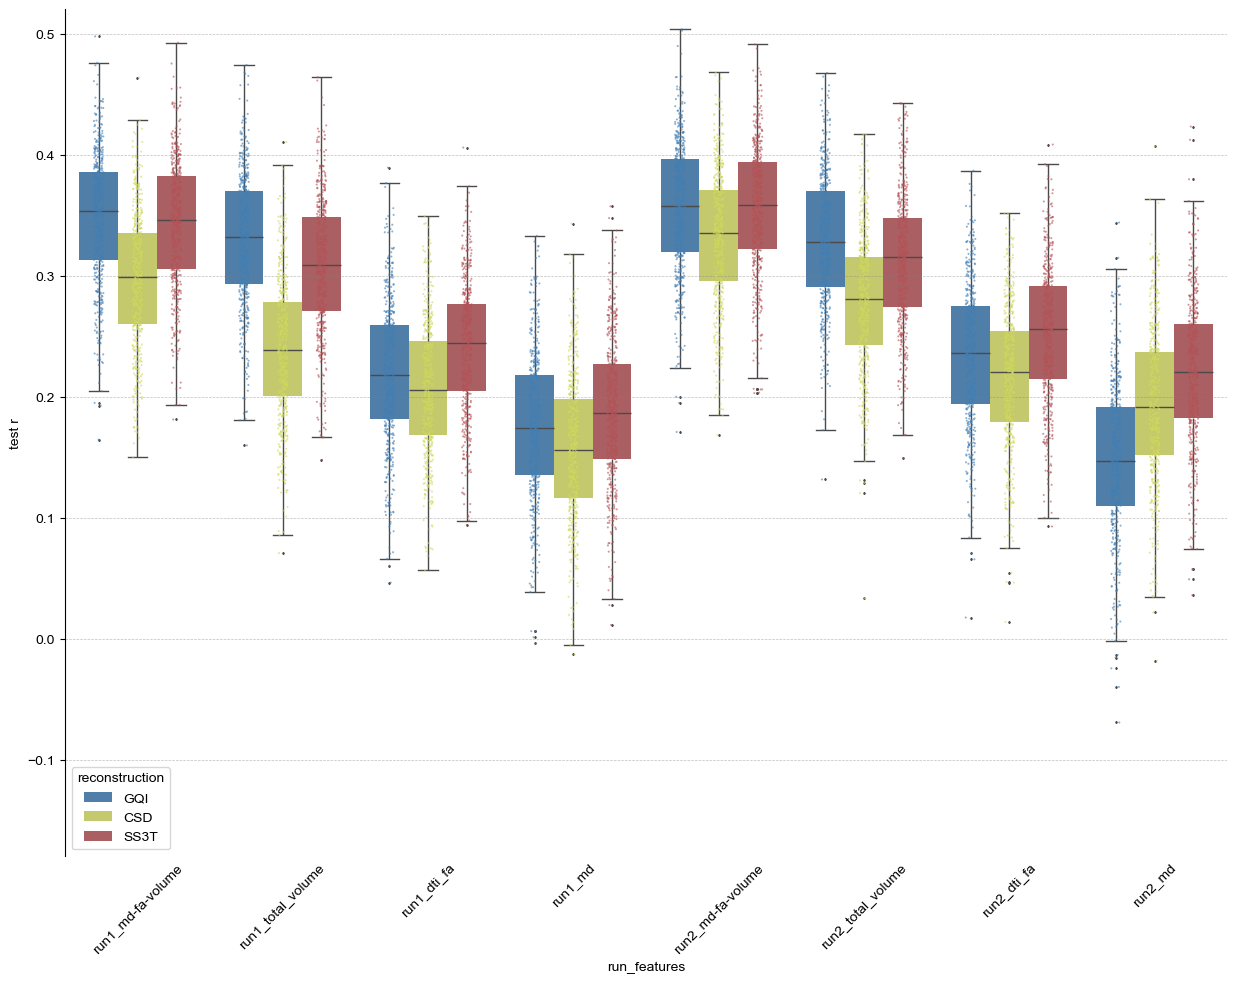

In [33]:
# Plot
# Set colors, font and figure size
my_palette = sns.color_palette(
    [(64/255, 127/255, 183/255), (208/255, 217/255, 92/255), (182/255, 82/255, 86/255)])
sns.set_palette(my_palette)
plt.rcParams['figure.figsize'] = [15, 11]
if "Arial" in set(f.name for f in font_manager.fontManager.ttflist):
    mpl.rcParams["font.family"] = "Arial"

bp = sns.boxplot(result_df, x="run_features", y=ACCURACY_SCORE, hue="reconstruction", boxprops={
                 "edgecolor": "none"}, flierprops={"marker": "d"}, fliersize=1)
sns.stripplot(result_df, x="run_features", y=ACCURACY_SCORE, hue="reconstruction",
              legend=False, alpha=0.6, edgecolor="black", dodge=True, size=1.5)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.ylabel(y_label)
plt.xticks(rotation=45)

# depending on the accuracy score, the y-axis must be formatted differently
if ACCURACY_SCORE == "test_r_corr":
    for y in np.arange(-0.1, 0.6, 0.1):
        plt.axhline(y=y, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    bp.set_ylim(-0.18, 0.52)
elif ACCURACY_SCORE == "test_neg_mean_squared_error":
    ymin, ymax = bp.get_ylim()
    lines = np.arange(np.floor(ymin/0.1)*0.1, np.ceil(ymax/0.1)*0.1, 0.1)
    for y in lines:
        plt.axhline(y=y, color="gray", linewidth=0.5, linestyle="--", alpha=0.5)

plt.tick_params(axis="x", which="both", length=0)
plt.gca().spines["left"].set_visible(True)
plt.savefig(f"{SAVE_ROOT}/{SAVE_NAME}")
plt.show()